# MNIST classification with PyTorch

## Fully connected layers vs Convolutional Neural Network (CNN)

Adapted from: https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

## Cell color
- Pink: Related to FCN (Fully-connected network) model
- Yellow: Related to CNN (Convolutional Neural network) model
- Skyblue: Related to visualization

### Required Python Packages
- `torch`
- `torchvision`
- `matplotlib`
- `tqdm`

Run the following cell to install the packages. 

In [ ]:
#
# Required Packages
#   Run this cell to install required packages
#
!pip install "torch>=1.9+cpu"
!pip install "torchvision>=0.10.1+cpu"
!pip install "matplotlib>=3.5"
!pip install "tqdm>=4.64"

In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### Load the Dataset (MNIST)

In [2]:
input_size  = 28 * 28  # images are 28x28 pixels
output_size = 10  # there are 10 classes

train_loader = DataLoader(
    datasets.MNIST('mnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=256, shuffle=True)

test_loader = DataLoader(
    datasets.MNIST('mnist', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=False)

/home/jovyan/.local/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


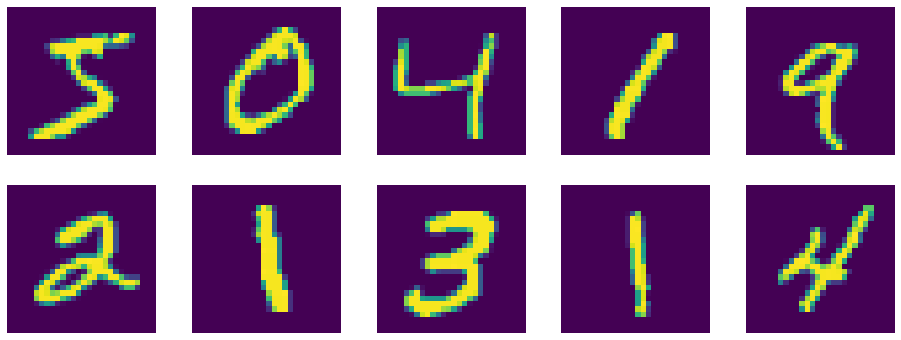

In [3]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

### Train and test functions

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
accuracy_list = []

def train(epoch, model, optimizer):
    model.train()
    print(f"Train Epoch {epoch}")
    
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28 * 28)
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f"loss: {loss.item():.4f}")
        
        
def test(model, data_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            # send to device
            data, target = data.to(device), target.to(device)

            # permute pixels
            data = data.view(-1, 28 * 28)
            data = data.view(-1, 1, 28, 28)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
            correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(data_loader)
    accuracy = 100. * correct / len(data_loader.dataset)
    return test_loss, accuracy

    
# get number of parameters in the model
def get_n_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### CNN model

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=cnn_hidden_channels, kernel_size=cnn_kernel_size)
        self.conv2 = nn.Conv2d(cnn_hidden_channels, cnn_hidden_channels, kernel_size=cnn_kernel_size)
        self.fc1 = nn.Linear(cnn_hidden_channels * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, cnn_hidden_channels * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

### FCN (Fully Connected Network) model

In [5]:
class FCN(nn.Module):
    def __init__(self, input_size):
        super(FCN, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, fcn_hidden), 
            nn.ReLU(inplace=False), 
            nn.Linear(fcn_hidden, fcn_hidden), 
            nn.ReLU(inplace=False), 
            nn.Linear(fcn_hidden, 10)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size)
        return self.network(x)

### Train and test CNN

In [9]:
model_cnn = CNN()
model_cnn.to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(epochs):
    train(epoch + 1, model_cnn, optimizer)    
    train_loss, cnn_train_acc = test(model_cnn, train_loader)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {cnn_train_acc:.2f}%')
    test_loss, cnn_test_acc = test(model_cnn, test_loader)
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {cnn_test_acc:.2f}%')

Number of parameters: 6274
Train Epoch 1


loss: 0.1957: 100%|██████████| 235/235 [00:40<00:00,  5.84it/s]


Train loss: 0.1825, Train accuracy: 94.60%
Test loss: 0.1658, Test accuracy: 95.00%


### Train and test FCN

In [6]:
model_fcn = FCN(28 * 28)
model_fcn.to(device)
optimizer = torch.optim.Adam(model_fcn.parameters(), lr=1e-3)
print('Number of parameters: {}'.format(get_n_params(model_fcn)))

for epoch in range(epochs):
    train(epoch + 1, model_fcn, optimizer)
    train_loss, fcn_train_acc = test(model_fcn, train_loader)
    print(f'Train loss: {train_loss:.4f}, Train accuracy: {fcn_train_acc:.2f}%')
    test_loss, fcn_test_acc = test(model_fcn, test_loader)
    print(f'Test loss: {test_loss:.4f}, Test accuracy: {fcn_test_acc:.2f}%')

Number of parameters: 6442
Train Epoch 1


loss: 0.6298: 100%|██████████| 235/235 [00:31<00:00,  7.54it/s]


Train loss: 0.6959, Train accuracy: 78.56%
Test loss: 0.6915, Test accuracy: 78.79%


### Visualize results

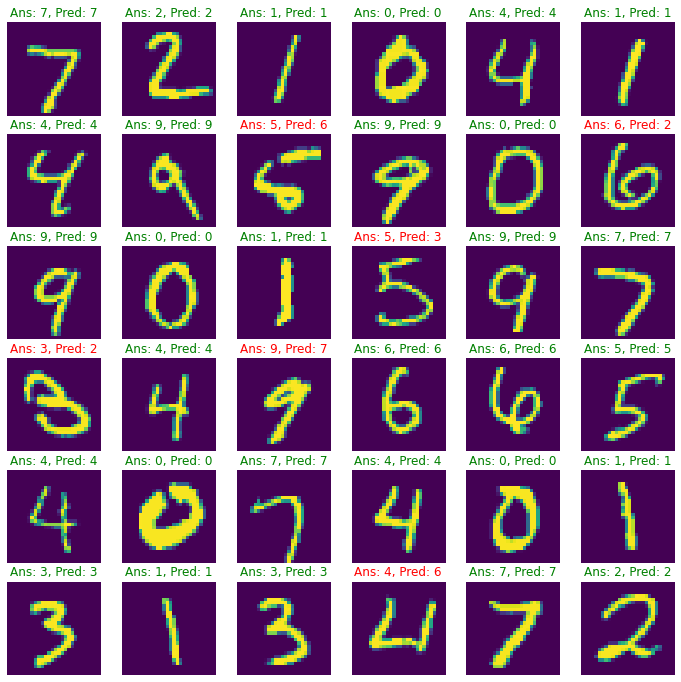

In [7]:
plt.figure(figsize=(12, 12))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    image, label = test_loader.dataset.__getitem__(i)
    pred = model_fcn(image)
    _, pred = pred.max(dim=1)
    color = "g" if label == pred.item() else "r"
    plt.title(f"Ans: {label}, Pred: {pred.item()}", color=color)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

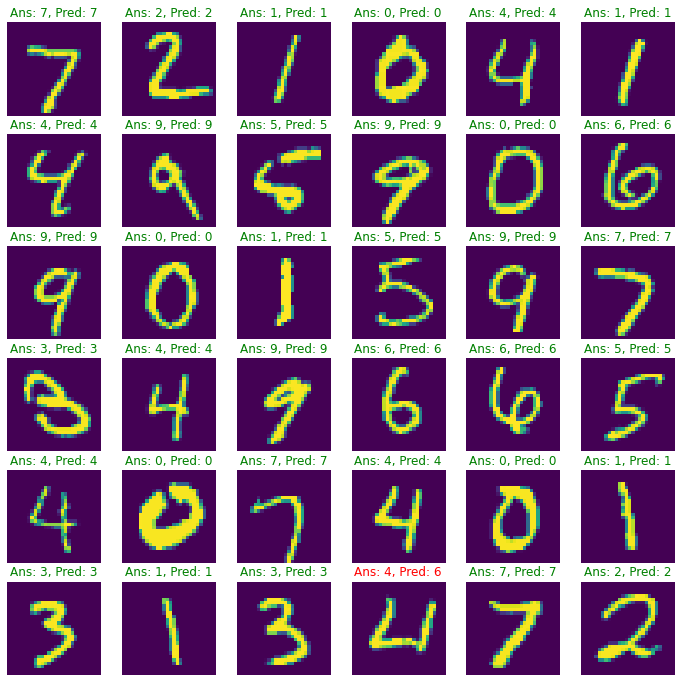

In [10]:
plt.figure(figsize=(12, 12))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    image, label = test_loader.dataset.__getitem__(i)
    pred = model_cnn(image.unsqueeze(0))
    _, pred = pred.max(dim=1)
    color = "g" if label == pred.item() else "r"
    plt.title(f"Ans: {label}, Pred: {pred.item()}", color=color)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

### Compare the performance of FCN and CNN, which is better?